In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories
from src.tools import load_dataset

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
batch_size = 256
lr = 1e-4
n_steps = 100
GAMMA = 0.0
G_ITERS = 5
D_ITERS = 1
f_ITERS = 10
MAX_STEPS = 50000


ZC = 1
Z_STD = 1.0

In [3]:
sampler3, test_sampler3 = load_dataset('MNIST-colored_3', './datasets/MNIST', img_size=32, batch_size=batch_size)
sampler2, test_sampler2 = load_dataset('MNIST-colored_2', './datasets/MNIST', img_size=32, batch_size=batch_size)

In [4]:
X_sampler = sampler3
Y_sampler = sampler2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


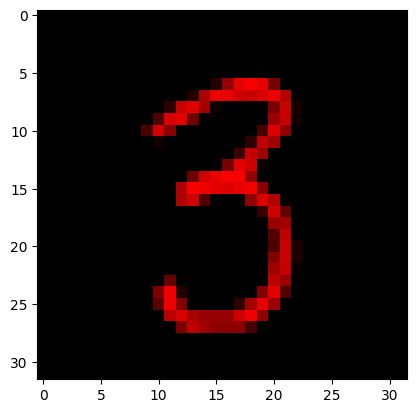

In [5]:
tensor_image = X_sampler.sample(1)[0].cpu()
plt.imshow(tensor_image.permute(1, 2, 0))

In [6]:
IMG_SIZE = 32
IMG_CHANNELS = 3
ZC = 1

TIME_DIM = 128
UNET_BASE_FACTOR = 48
EPSILON = 0.0
N_STEPS = 100

In [7]:
def trainGD(X_sampler, Y_sampler, sde, sde_opt, G, G_opt, D, D_opt, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):

        for G_iter in range(G_ITERS):

            x0 = X_sampler.sample(batch_size)
            Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE), device='cuda') * Z_STD

            xN = G(torch.cat([x0, Z], axis = 1))

            G_loss = F.mse_loss(x0, xN).mean() - D(xN).mean()
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()

        
        if step % 10 == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 2, figsize=(15, 5.2), dpi=150, sharex=True, sharey=True, )
            axes[0].imshow(x0[0].cpu().detach().permute(1, 2, 0))
            axes[1].imshow(xN[0].cpu().detach().permute(1, 2, 0))
            plt.show()
        
    
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE), device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = 1))
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

In [8]:
from MNIST_models.cunet import CUNet
from MNIST_models.resnet import ResNet_D
from MNIST_models.unet import UNet
from MNIST_models.enot import SDE

In [9]:
D = ResNet_D(IMG_SIZE, nc=IMG_CHANNELS).cuda()
G = UNet(IMG_CHANNELS+ZC, IMG_CHANNELS, base_factor=UNET_BASE_FACTOR).cuda()


f = CUNet(IMG_CHANNELS, IMG_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR).cuda()
sde = SDE(shift_model=f, epsilon=EPSILON, n_steps=N_STEPS,
        time_dim=TIME_DIM, n_last_steps_without_noise=5,
        use_positional_encoding=True,
        use_gradient_checkpoint=False,
        predict_shift=True, image_input=True).cuda()
    
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))
print('G params:', np.sum([np.prod(p.shape) for p in G.parameters()]))
print('sde params:', np.sum([np.prod(p.shape) for p in sde.parameters()]))

D params: 13494209
G params: 9716259
sde params: 9934611


In [10]:
sde_opt = Adam(sde.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)

In [11]:
# stats = trainGD(X_sampler, Y_sampler, sde, sde_opt, G, G_opt, D, D_opt, plot_n_samples=1000)

In [12]:
# torch.save(G, 'G_MNIST.pt')
# torch.save(D, 'D_MNIST.pt')

In [13]:
G = torch.load('G_MNIST.pt')
D = torch.load('D_MNIST.pt')

In [14]:
def trainf(X_sampler, Y_sampler, sde, sde_opt, G, G_opt, D, D_opt, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):

        x0 = X_sampler.sample(batch_size)
        Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE), device='cuda') * Z_STD
        xN = G(torch.cat([x0, Z], axis = 1))
        
        
        t = (torch.rand(x0.shape[0])*0.995).cuda()
        xt = x0 + (xN - x0) * t[:, None, None, None] + torch.randn_like(x0)*(torch.sqrt(t*(1-t)*GAMMA)[:, None, None, None])
        
        f_loss = ((sde._get_shift(xt, t) - (xN - xt)/(1-t[:, None, None, None])) ** 2).mean()
        sde_opt.zero_grad(); f_loss.backward(); sde_opt.step()

        
        if step % 100 == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 2, figsize=(15, 5.2), dpi=150, sharex=True, sharey=True, )
            x0 = X_sampler.sample(1)
            trajectory = sde(x0)
            xN = trajectory[:, -1]
            axes[0].imshow(x0[0].cpu().detach().permute(1, 2, 0))
            axes[1].imshow(xN[0].cpu().detach().permute(1, 2, 0))
            plt.show()

            
    return (G_mse, G_var, sde_mse, sde_var)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


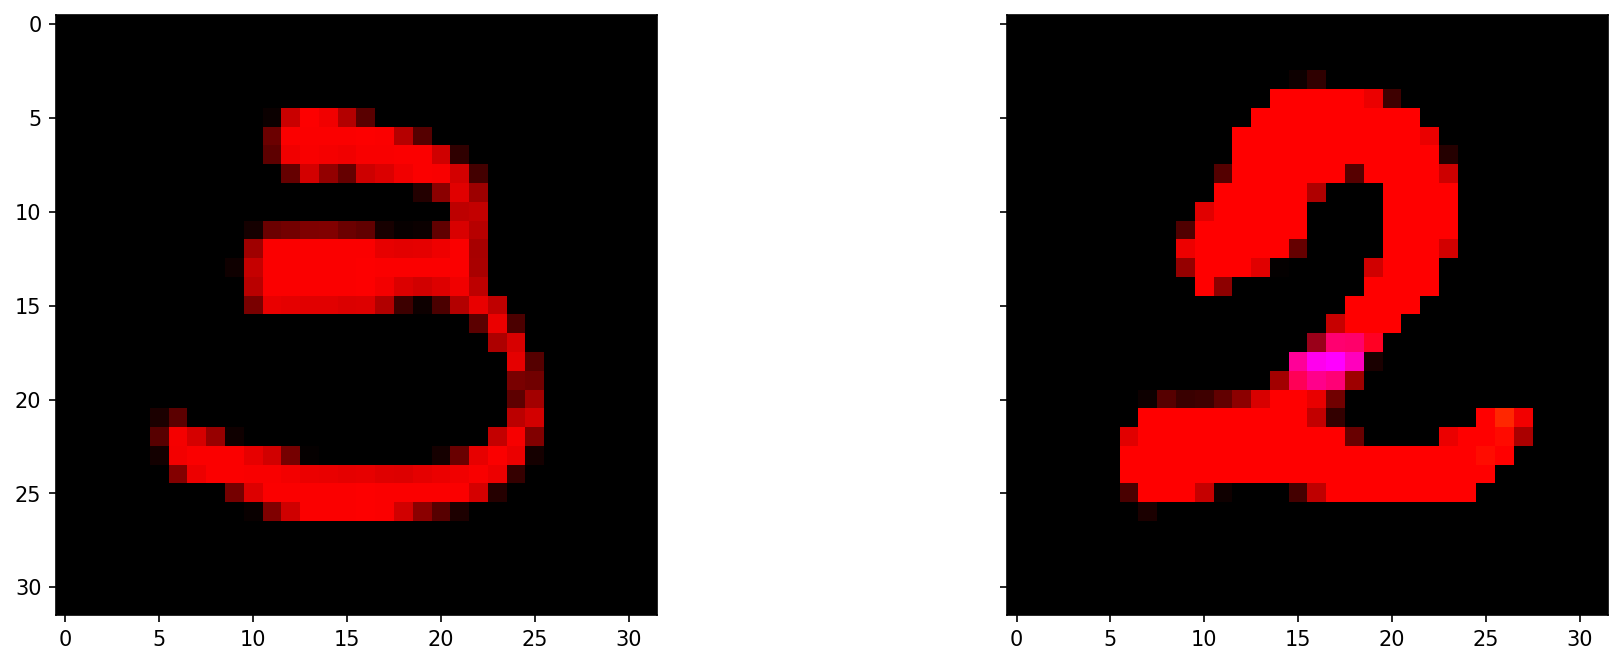

100%|██████████| 50000/50000 [4:19:46<00:00,  3.21it/s]


In [15]:
stats = trainf(X_sampler, Y_sampler, sde, sde_opt, G, G_opt, D, D_opt, plot_n_samples=1000)

In [16]:
torch.save(sde, 'sde.pt')